In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/ECE_661/ECE_661_Project/WGAN"

/content/drive/MyDrive/ECE_661/ECE_661_Project/WGAN


In [3]:
import os
import uuid
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.utils.tensorboard as tensorboard
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

In [4]:
from os import truncate
import torch
import torch.nn as nn

# Define the critic (discriminator) and generator networks
class Critic(nn.Module):
    def __init__(self, channels_img, features):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.LeakyReLU(0.2),
            self._block(features, features * 2, 4, 2, 1),  # 16x16
            self._block(features * 2, features * 4, 4, 2, 1),  # 8x8
            self._block(features * 4, features * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(features * 8, 1, kernel_size=2, stride=2, padding=0),  # 1x1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.critic(x)

class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img, features):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x noise_dim x 1 x 1
            self._block(noise_dim, features * 16, 4, 1, 0),
            self._block(features * 16, features * 8, 4, 2, 1),
            self._block(features * 8, features * 4, 4, 2, 1),
            nn.ConvTranspose2d(features * 4, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),  # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 32, 32
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    critic = Critic(in_channels, 8)
    initialize_weights(critic)
    assert critic(x).shape == (N, 1, 1, 1)
    gen = Generator(noise_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, noise_dim, 1, 1))
    print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

test()

torch.Size([8, 3, 32, 32])
Success


In [5]:
# Hyperparams

# Constants
BATCH_SIZE = 64
IMG_SIZE = 32
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GRAD_PENALTY = 10

# Potentially loaded from saved model
learning_rate = 1e-4
global_epoch = 0

In [6]:
# Model Save Constants
# GAN_ID = str(uuid.uuid4()) # generate a new random id for a GAN instance
# GAN_ID = "70d918dc-5df1-46de-afe1-65411878f698" # model 1
# GAN_ID = "81ec7011-7123-4fa6-9b4a-4a07868c2425" # model 2
# GAN_ID = "d6408c91-baed-4b22-8dd9-e3b07a1bf3de" # model 3 FIXED NORMALIZATION BUG HERE
GAN_ID = "6c9f2d1d-1924-463f-a55b-3d8c61e295c6" # model 4 FIXED IMAGE SIZE TO 32x32

print(f"ID: {GAN_ID}")
MODEL_INSTANCE_FOLDER = os.path.join("./saved_models", GAN_ID)
MODEL_OUTPUTS_FOLDER = os.path.join("./outputs", GAN_ID)
FILE_NAME_GEN = "gen.pth"
FILE_NAME_CRITIC = "critic.pth"
FILE_PATH_GEN = os.path.join(MODEL_INSTANCE_FOLDER, FILE_NAME_GEN)
FILE_PATH_CRITIC = os.path.join(MODEL_INSTANCE_FOLDER, FILE_NAME_CRITIC)

ID: 6c9f2d1d-1924-463f-a55b-3d8c61e295c6


In [7]:
# load data
print("==> Preparing data...")

data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=data_transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

==> Preparing data...
Files already downloaded and verified


In [8]:
# functions for saving and loading model states

def get_model_state(file_path):
    if os.path.exists(file_path):
        print(f"found model state at path {file_path}")
        return torch.load(file_path)
    print(f"No model state found at path {file_path}")
    return None

def save_model_state(model, epoch, current_learning_rate, file_path):
    if not os.path.exists(MODEL_INSTANCE_FOLDER):
        os.makedirs(MODEL_INSTANCE_FOLDER)
    print("Saving ...")
    state = {'state_dict': model.state_dict(),
            'epoch': epoch,
            'lr': current_learning_rate,
            'id': GAN_ID}
    torch.save(state, file_path)

def initialize_model_state(model, model_state):
    if model_state is not None:
        model.load_state_dict(model_state['state_dict'])
    else:
        initialize_weights(model)

In [16]:
# initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

model_state_gen = get_model_state(FILE_PATH_GEN)
model_state_critic = get_model_state(FILE_PATH_CRITIC)

initialize_model_state(gen, model_state_gen)
initialize_model_state(critic, model_state_critic)

if model_state_gen is not None and model_state_critic is not None:
    learning_rate = model_state_gen['lr']
    global_epoch = model_state_gen['epoch']
    print(f"loaded previous model at epoch {global_epoch}")
elif model_state_gen is not None or model_state_critic is not None:
    print("error: model(s) potentially missing")
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0, 0.9))

found model state at path ./saved_models/6c9f2d1d-1924-463f-a55b-3d8c61e295c6/gen.pth
found model state at path ./saved_models/6c9f2d1d-1924-463f-a55b-3d8c61e295c6/critic.pth
loaded previous model at epoch 30


In [10]:
# enforce lipschitz constraint
def gradient_penalty(critic, real, fake, device="cpu"):
    if real.shape != fake.shape:
        print(f'real: {real.shape}')
        print(f'fake: {fake.shape}')

    batch_size, c, h, w = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [11]:
# save images during training
def create_sample_seeding():
    batch_tensors = []
    for i in range(20):
        batch_tensors.append(torch.normal(mean=0, std = 1, size = (NOISE_DIM, 1, 1))) # better to use uniform random or normal random?
    final_tensor = torch.stack(batch_tensors)
    return final_tensor

def sample_images(netG, save=False, epoch=0):
    seeds = create_sample_seeding()
    seeds = seeds.to(device)
    netG.eval()
    with torch.no_grad():
        imgs = netG(seeds)

    imgs = imgs / 2 + .5
    grid = torchvision.utils.make_grid(imgs, nrow=10, padding = 4)
    grid = grid.detach().cpu().numpy()
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    if save:
        if not os.path.exists(MODEL_OUTPUTS_FOLDER):
            os.makedirs(MODEL_OUTPUTS_FOLDER)
        plt.savefig(os.path.join(MODEL_OUTPUTS_FOLDER, f"img_e{epoch}.png"))
        np.save(os.path.join(MODEL_OUTPUTS_FOLDER, f"grid_e{epoch}.npy"), imgs.detach().cpu().numpy())
    else:
        plt.show()

def sample_real_images():
    data_iter = iter(loader)
    images, labels = next(data_iter)
    sample_image, sample_label = images[0], labels[0]
    sample_image = sample_image / 2 + .5
    plt.imshow(np.transpose(sample_image, (1,2,0)))
    plt.show()

In [12]:
def get_inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """
        Computes the inception score of the generated images imgs
        imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
        cuda -- whether or not to run on GPU
        batch_size -- batch size for feeding into Inception v3
        splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        print("1")
        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)
        print("2")

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

starting training at global_epoch: 30
1
2
Epoch 30               Loss C: -2.3682, Loss G: -43.7692, Inception Score: (2.8801717525026382, 0.0)
Saving ...


<ipython-input-12-334d6886d5cc>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Saving ...
1
2
Epoch 31               Loss C: -1.9203, Loss G: -38.2374, Inception Score: (2.341609213540419, 0.0)
Saving ...
Saving ...
1
2
Epoch 32               Loss C: -4.1978, Loss G: -41.2503, Inception Score: (3.075130424514643, 0.0)
Saving ...
Saving ...
1
2
Epoch 33               Loss C: -4.2177, Loss G: -37.0953, Inception Score: (3.2170859555344444, 0.0)
Saving ...
Saving ...
1
2
Epoch 34               Loss C: -2.4653, Loss G: -41.5528, Inception Score: (2.4219115028864038, 0.0)
Saving ...
Saving ...


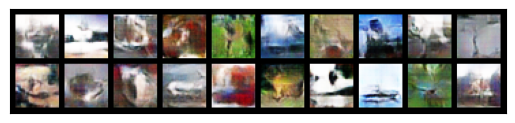

In [17]:
# Training loop
gen.train()
critic.train()

NUM_EPOCHS = 5

print(f"starting training at global_epoch: {global_epoch}")

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(real.shape[0], NOISE_DIM, 1, 1).to(device)

            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)

            grad_penalty = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GRAD_PENALTY * grad_penalty
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # train generator
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    with torch.no_grad():
        noise = torch.randn(real.shape[0], NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)
        print(
            f"Epoch {global_epoch} \
              Loss C: {loss_critic:.4f}, Loss G: {loss_gen:.4f}, Inception Score: {get_inception_score(fake, resize=True)}"
        )
        sample_images(gen, save=True, epoch=global_epoch)

    global_epoch += 1

    save_model_state(gen, global_epoch, learning_rate, FILE_PATH_GEN)
    save_model_state(critic, global_epoch, learning_rate, FILE_PATH_CRITIC)

found model state at path ./saved_models/d6408c91-baed-4b22-8dd9-e3b07a1bf3de/gen.pth
found model state at path ./saved_models/d6408c91-baed-4b22-8dd9-e3b07a1bf3de/critic.pth


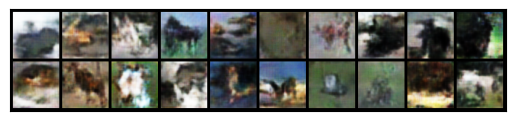

In [ ]:
# score model
device = "cuda" if torch.cuda.is_available() else "cpu"

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

model_state_gen = get_model_state(FILE_PATH_GEN)
model_state_critic = get_model_state(FILE_PATH_CRITIC)

initialize_model_state(gen, model_state_gen)
initialize_model_state(critic, model_state_critic)

sample_images(gen, save=True, epoch=-1)

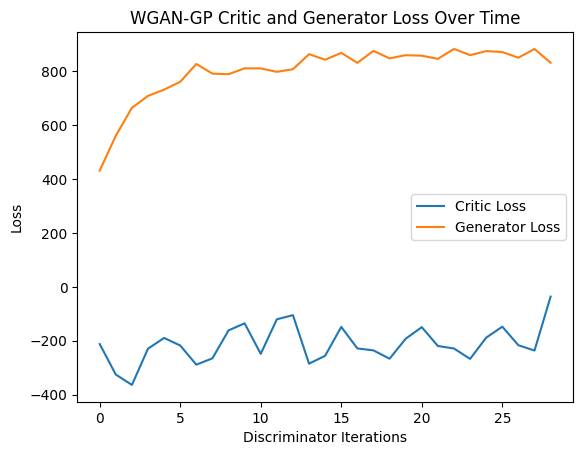

In [ ]:
loss_c = [-212.1301, -325.3906, -363.9003, -229.2936, -189.5060, -217.5478, -288.6822, -265.1539, -161.4207, -135.1734, -248.5016, -120.1847, -104.8588, -284.9915, -255.5687, -148.4905, -228.3616, -235.6613, -266.5198, -192.4482, -149.2888, -219.2783, -228.7079, -267.2667, -188.3804, -147.6326, -216.5600, -236.2306, -36.0587]
loss_g = [431.8856, 561.1833, 665.0902, 709.3152, 732.6298, 761.5820, 827.7739, 791.9473, 789.8314, 811.7239, 811.3880, 798.6318, 808.3373, 864.2098, 843.5181, 869.1351, 831.9880, 876.5120, 848.6161, 860.4373, 858.6585, 846.7895, 883.7273, 860.6360, 875.5989, 872.0737, 851.1183, 883.5458, 832.3641]

epochs = list(range(len(loss_c)))

plt.plot(epochs, loss_c, label='Critic Loss')
plt.plot(epochs, loss_g, label='Generator Loss')

# Add labels and title
plt.xlabel('Discriminator Iterations')
plt.ylabel('Loss')
plt.title('WGAN-GP Critic and Generator Loss Over Time')

# Add legend
plt.legend()

# Show the plot
plt.show()
